In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import wandb
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


In [ ]:
wandb.login()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m008 (da24m008-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
# Initialize wandb
wandb.init(project="DA6401-A2-V4", name="finet-tunning-using-resnet50")

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths
data_dir = r"/kaggle/input/inatural-12k/inaturalist_12K"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "val")  # We'll use the original val as test

# Data augmentation and normalization
# Using ImageNet mean and std since we're using a pre-trained model
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load the full training dataset
full_train_dataset = ImageFolder(train_dir, transform=data_transforms['train'])

# Split the training data into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.19.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250419_104135-jfa1mp94
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run finet-tunning-using-resnet50
wandb: ⭐️ View project at https://wandb.ai/da24m008-iit-madras/DA6401-A2-V4
wandb: 🚀 View run at https://wandb.ai/da24m008-iit-madras/DA6401-A2-V4/runs/jfa1mp94


Using device: cuda:0


In [4]:
# Create a proper validation dataset with validation transforms
class TransformedSubset:
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        # Apply the proper validation transform
        if self.transform:
            # Get the original image before any transforms
            original_img_path = self.subset.dataset.samples[self.subset.indices[idx]][0]
            from PIL import Image
            img = Image.open(original_img_path).convert('RGB')
            x = self.transform(img)
        return x, y
    
    def __len__(self):
        return len(self.subset)


In [5]:
# Apply validation transforms to validation split
val_dataset = TransformedSubset(val_dataset, data_transforms['val'])

# Load the test dataset
test_dataset = ImageFolder(test_dir, transform=data_transforms['test'])

# Create data loaders
batch_size = 32
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

# Get dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}

# Get class names
class_names = full_train_dataset.classes
num_classes = len(class_names)

print(f"Number of training samples: {dataset_sizes['train']}")
print(f"Number of validation samples: {dataset_sizes['val']}")
print(f"Number of test samples: {dataset_sizes['test']}")
print(f"Number of classes: {num_classes}")

# Log configuration to wandb
wandb.config.update({
    "num_classes": num_classes,
    "train_samples": dataset_sizes['train'],
    "val_samples": dataset_sizes['val'],
    "test_samples": dataset_sizes['test'],
    "model": "ResNet50",
    "fine_tuning_strategy": "freeze_except_last_layer",
    "batch_size": batch_size
})


Number of training samples: 7999
Number of validation samples: 2000
Number of test samples: 2000
Number of classes: 10


In [6]:
# Function to visualize sample images
def visualize_samples(dataloader, num_images=5):
    batch = next(iter(dataloader))
    images, labels = batch
    
    plt.figure(figsize=(15, 6))
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i + 1)
        # Convert tensor to numpy and transpose to (H,W,C)
        img = images[i].numpy().transpose((1, 2, 0))
        # De-normalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        plt.title(f"Class: {class_names[labels[i]]}")
    plt.tight_layout()
    plt.savefig("sample_images.png")
    wandb.log({"sample_images": wandb.Image("sample_images.png")})


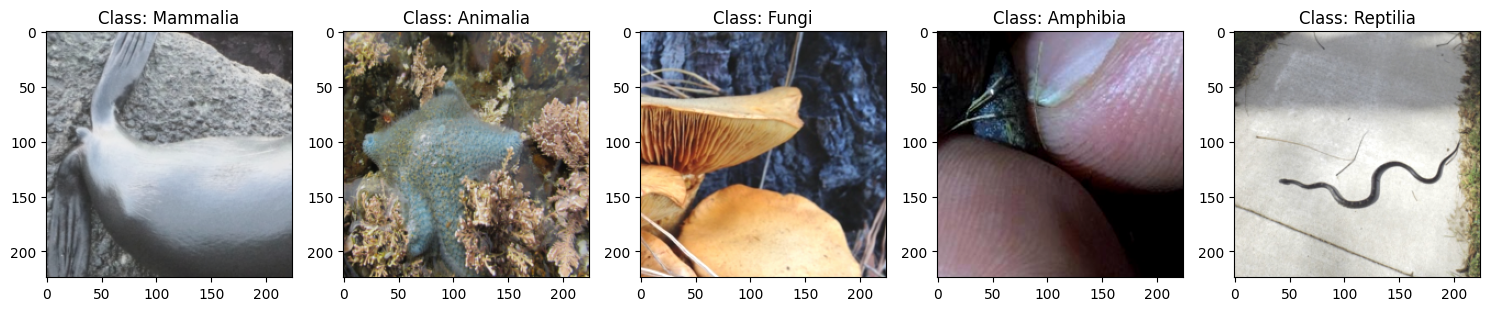

In [7]:
# Visualize some training images
visualize_samples(dataloaders['train'])

In [8]:
# Load pre-trained ResNet50 model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Strategy 1: Freeze all layers except the last layer
# First, freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# ResNet50's fc layer has shape (2048, 1000) where 1000 is the number of ImageNet classes
# We need to modify it for our number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Move model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Only optimize the parameters of the final layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]


In [9]:
# Function to train the model
def train_model(model, criterion, optimizer, num_epochs=25):
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase} phase"):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Log metrics to wandb
            wandb.log({
                f"{phase}_loss": epoch_loss,
                f"{phase}_accuracy": epoch_acc,
                "epoch": epoch
            })
            
            # Save the best model based on validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_model.pth')
                wandb.save('best_model.pth')
                
    print(f'Best val Acc: {best_acc:.4f}')
    return model


In [10]:
# Train the model
num_epochs = 10
model = train_model(model, criterion, optimizer, num_epochs=num_epochs)


Epoch 1/10
----------


train phase: 100%|██████████| 250/250 [00:54<00:00,  4.61it/s]


train Loss: 1.1229 Acc: 0.6311


val phase: 100%|██████████| 63/63 [00:22<00:00,  2.83it/s]


val Loss: 0.6926 Acc: 0.7630
Epoch 2/10
----------


train phase: 100%|██████████| 250/250 [00:43<00:00,  5.73it/s]


train Loss: 0.8537 Acc: 0.7163


val phase: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]


val Loss: 0.6479 Acc: 0.7855
Epoch 3/10
----------


train phase: 100%|██████████| 250/250 [00:44<00:00,  5.67it/s]


train Loss: 0.8224 Acc: 0.7288


val phase: 100%|██████████| 63/63 [00:20<00:00,  3.12it/s]


val Loss: 0.6430 Acc: 0.7870
Epoch 4/10
----------


train phase: 100%|██████████| 250/250 [00:43<00:00,  5.71it/s]


train Loss: 0.8046 Acc: 0.7307


val phase: 100%|██████████| 63/63 [00:19<00:00,  3.15it/s]


val Loss: 0.6137 Acc: 0.8055
Epoch 5/10
----------


train phase: 100%|██████████| 250/250 [00:43<00:00,  5.77it/s]


train Loss: 0.7935 Acc: 0.7401


val phase: 100%|██████████| 63/63 [00:19<00:00,  3.16it/s]


val Loss: 0.6651 Acc: 0.7820
Epoch 6/10
----------


train phase: 100%|██████████| 250/250 [00:43<00:00,  5.76it/s]


train Loss: 0.8075 Acc: 0.7351


val phase: 100%|██████████| 63/63 [00:20<00:00,  3.05it/s]


val Loss: 0.6125 Acc: 0.7970
Epoch 7/10
----------


train phase: 100%|██████████| 250/250 [00:43<00:00,  5.81it/s]


train Loss: 0.7649 Acc: 0.7475


val phase: 100%|██████████| 63/63 [00:19<00:00,  3.17it/s]


val Loss: 0.6079 Acc: 0.8090
Epoch 8/10
----------


train phase: 100%|██████████| 250/250 [00:42<00:00,  5.90it/s]


train Loss: 0.8010 Acc: 0.7350


val phase: 100%|██████████| 63/63 [00:20<00:00,  3.15it/s]


val Loss: 0.6193 Acc: 0.8050
Epoch 9/10
----------


train phase: 100%|██████████| 250/250 [00:41<00:00,  5.95it/s]


train Loss: 0.7620 Acc: 0.7467


val phase: 100%|██████████| 63/63 [00:19<00:00,  3.17it/s]


val Loss: 0.5980 Acc: 0.8025
Epoch 10/10
----------


train phase: 100%|██████████| 250/250 [00:41<00:00,  5.96it/s]


train Loss: 0.7783 Acc: 0.7445


val phase: 100%|██████████| 63/63 [00:20<00:00,  3.13it/s]

val Loss: 0.5963 Acc: 0.8090
Best val Acc: 0.8090


In [11]:
# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    running_corrects = 0
    # Store all predictions and true labels
    all_preds = []
    all_labels = []
    
    # Confusion matrix
    confusion_matrix = torch.zeros(num_classes, num_classes)
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Update statistics
            running_corrects += torch.sum(preds == labels.data)
            
            # Store predictions and labels for wandb
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update confusion matrix
            for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    
    # Calculate accuracy
    test_acc = running_corrects.double() / dataset_sizes['test']
    print(f'Test Accuracy: {test_acc:.4f}')
    
    # Calculate per-class accuracy
    per_class_acc = confusion_matrix.diag() / confusion_matrix.sum(1)
    for i, acc in enumerate(per_class_acc):
        print(f'Accuracy of {class_names[i]}: {acc:.4f}')
    
    # Log metrics to wandb
    wandb.log({
        "test_accuracy": test_acc.item(),
        "confusion_matrix": wandb.plot.confusion_matrix(
            preds=all_preds,  # Using collected predictions
            y_true=all_labels,  # Using collected true labels
            class_names=class_names
        )
    })
    
    return test_acc

In [12]:
# Evaluate on the test set
test_acc = evaluate_model(model, dataloaders['test'])

# Finish wandb run
wandb.finish()

Testing: 100%|██████████| 63/63 [00:13<00:00,  4.84it/s]


Test Accuracy: 0.8000
Accuracy of Amphibia: 0.8000
Accuracy of Animalia: 0.8000
Accuracy of Arachnida: 0.8250
Accuracy of Aves: 0.9100
Accuracy of Fungi: 0.8250
Accuracy of Insecta: 0.8300
Accuracy of Mammalia: 0.7850
Accuracy of Mollusca: 0.6300
Accuracy of Plantae: 0.8350
Accuracy of Reptilia: 0.7600


wandb: uploading artifact run-jfa1mp94-confusion_matrix_table
wandb: 
wandb: uploading best_model.pth
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:          epoch ▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
wandb:  test_accuracy ▁
wandb: train_accuracy ▁▆▇▇█▇█▇██
wandb:     train_loss █▃▂▂▂▂▁▂▁▁
wandb:   val_accuracy ▁▄▅▇▄▆█▇▇█
wandb:       val_loss █▅▄▂▆▂▂▃▁▁
wandb: 
wandb: Run summary:
wandb:          epoch 9
wandb:  test_accuracy 0.8
wandb: train_accuracy 0.74447
wandb:     train_loss 0.77832
wandb:   val_accuracy 0.809
wandb:       val_loss 0.59627
wandb: 
wandb: 🚀 View run finet-tunning-using-resnet50 at: https://wandb.ai/da24m008-iit-madras/DA6401-A2-V4/runs/jfa1mp94
wandb: ⭐️ View project at: https://wandb.ai/da24m008-iit-madras/DA6401-A2-V4
wandb: Synced 5 W&B file(s), 2 media file(s), 2 artifact file(s) and 1 other file(s)
wandb: Find logs at: ./wandb/run-20250419_104135-jfa1mp94/logs
